# Diabetes readmission prediction

Import libraries for later use:

In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import os
import subprocess
from operator import itemgetter
from helper import EstimatorSelectionHelper
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from sklearn.preprocessing import RobustScaler

In [2]:
EMB_SIZE = 512  # Size of universal sentence encoder embeddings 
useDummy = True  # Whether to use 1hot encoding or ordinal

To avoid confusion we will only present the results achieved with 1hot encoding, which after experimentation seemed to offer better results. We also tried a couple of embeding sizes without noticing significant differences in performance. These among other experimentation insights will be listed at the end of the notebook.

Importing dataframes:

In [12]:
train_df = pd.read_csv('project2_data/10k_diabetes/diab_train.csv')
valid_df = pd.read_csv('project2_data/10k_diabetes/diab_validation.csv')
test_df = pd.read_csv('project2_data/10k_diabetes/diab_test.csv')

## Preprocessing

The following columns provide no information or contain too many nans:

In [3]:
to_remove = ['Unnamed: 0', 'weight', 'payer_code', 'discharge_disposition_id', 'admission_source_id',
             'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult']

In [4]:
# Values mapped to nan
NaN_values = ['?', 'nan', 'Not Available', 'Not Mapped', 'None']

# Prediction
pred_columns = ['readmitted']

# All integer columns
int_columns = ['time_in_hospital', 'num_lab_procedures',
               'num_procedures', 'num_medications', 'number_outpatient',
               'number_emergency', 'number_inpatient', 'number_diagnoses',
               ]

# All categorical columns
cat_columns = ['race', 'gender', 'age', 'metformin', 'repaglinide', 'nateglinide',
               'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
               'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
               'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
               'insulin', 'glyburide.metformin', 'glipizide.metformin',
               'glimepiride.pioglitazone', 'metformin.rosiglitazone',
               'metformin.pioglitazone', 'change', 'diabetesMed'
               ]


# All string columns
str_columns = ['diag_1_desc', 'diag_2_desc', 'diag_3_desc']

In [5]:
# create dictionary mapping each category to a number
def create_maps(df, cat_columns, nan_categories):
    maps = {}
    for column in cat_columns:
        maps[column] = {category: i for i,
                        category in enumerate(df[column].unique())}

    for key in maps.keys():
        for category in maps[key]:
            if category in nan_categories:
                maps[key][category] = np.NaN
    return maps


def fix_integers(df, int_columns):
    for column in int_columns:
        df[column] = df[column].where(
            lambda x: [str(i).isdigit() for i in x], np.NaN).astype(np.float)
    return df


# encode categories into numbers using create_maps output
def fix_categories(df, cat_columns, cat_map):
    for column in cat_columns:
        df[column] = df[column].replace(cat_map[column])
        df[column] = df[column].astype('float64')
    return df


# map different nan strings to nan value
def set_NaN(df, cat_columns, nan_values):
    nan_map = {key: np.NaN for key in nan_values}
    for column in cat_columns:
        df[column] = df[column].replace(nan_map)
    return df


def create_missing_columns(df, unique_columns):
    for column in unique_columns:
        if column not in df.columns:
            df[column] = 0
    return df


def remove_columns(df, to_remove):
    return df.drop(columns=to_remove)

In [16]:
# remove uninteresting features
train_df = remove_columns(train_df, to_remove)
valid_df = remove_columns(valid_df, to_remove)
test_df = remove_columns(test_df, to_remove)

# Fix the Integers - Set all the unknown to 0
train_df = fix_integers(train_df, int_columns)
valid_df = fix_integers(valid_df, int_columns)
test_df = fix_integers(test_df, int_columns)

# Find category map
# category_map = create_maps(pd.concat((train_df, valid_df, test_df)), cat_columns, NaN_values)

Hard coded result of create_maps:

In [6]:
category_map = {'race': {'AfricanAmerican': 0, 'Caucasian': 1, 'Asian': 2, 'Other': 3, 'Hispanic': 4, '?': np.NaN},
                'gender': {'Male': 0, 'Female': 1},
                'age': {'[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4, '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9},
                'weight': {'?': np.NaN, '[0-25)': 1, '[25-50)': 2, '[50-75)': 3, '[75-100)': 4, '[100-125)': 5, '[125-150)': 6, '[150-175)': 7},
                'max_glu_serum': {'None': np.NaN, 'Norm': 1, '>200': 2, '>300': 3},
                'A1Cresult': {'None': 0, '>8': 1, 'Norm': 2, '>7': 3},
                'metformin': {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3},
                'repaglinide': {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3},
                'nateglinide': {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3},
                'chlorpropamide': {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3},
                'glimepiride': {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3},
                'acetohexamide': {'No': 0},
                'glipizide': {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3},
                'glyburide': {'No': 0, 'Steady': 1, 'Down': 2, 'Up': 3},
                'tolbutamide': {'No': 0, 'Steady': 1},
                'pioglitazone': {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3},
                'rosiglitazone': {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3},
                'acarbose': {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3},
                'miglitol': {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3},
                'troglitazone': {'No': 0},
                'tolazamide': {'No': 0, 'Steady': 1},
                'examide': {'No': 0},
                'citoglipton': {'No': 0},
                'insulin': {'No': 0, 'Down': 1, 'Up': 2, 'Steady': 3},
                'glyburide.metformin': {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3},
                'glipizide.metformin': {'No': 0, 'Steady': 1, 'Up': 2, 'Down': 3},
                'glimepiride.pioglitazone': {'No': 0},
                'metformin.rosiglitazone': {'No': 0},
                'metformin.pioglitazone': {'No': 0},
                'change': {'No': 0, 'Ch': 1},
                'diabetesMed': {'No': 0, 'Yes': 1},
                'admission_type_id': {'Emergency': 0, 'Elective': 1, 'Urgent': 2, 'Newborn': 3, 'Not Available': np.NaN,
                                      'Not Mapped': np.NaN},
                'medical_specialty': {'?': np.NaN, 'Family/GeneralPractice': 1, 'Emergency/Trauma': 2, 'InternalMedicine': 3,
                                      'Psychiatry': 4, 'Surgery-Neuro': 5, 'Surgery-General': 6, 'Cardiology': 7,
                                      'Orthopedics': 8, 'Orthopedics-Reconstructive': 9, 'Nephrology': 10,
                                      'Pediatrics-Pulmonology': 11, 'Gastroenterology': 12,
                                      'Surgery-Cardiovascular/Thoracic': 13, 'Osteopath': 14,
                                      'PhysicalMedicineandRehabilitation': 15, 'Hematology/Oncology': 16,
                                      'Surgery-Vascular': 17, 'Pediatrics-Endocrinology': 18, 'Oncology': 19,
                                      'ObstetricsandGynecology': 20, 'Urology': 21, 'Neurology': 22, 'Pulmonology': 23,
                                      'Surgery-Cardiovascular': 24, 'Radiologist': 25, 'OutreachServices': 26,
                                      'Surgery-Plastic': 27, 'Endocrinology': 28, 'Ophthalmology': 29,
                                      'Obsterics&Gynecology-GynecologicOnco': 30, 'Radiology': 31,
                                      'Surgery-Thoracic': 32, 'Pediatrics': 33, 'Psychology': 34, 'Otolaryngology': 35,
                                      'InfectiousDiseases': 36, 'Pediatrics-CriticalCare': 37, 'Gynecology': 38,
                                      'Pediatrics-Hematology-Oncology': 39, 'Surgeon': 40, 'Podiatry': 41,
                                      'Obstetrics': 42, 'Anesthesiology-Pediatric': 43, 'Hospitalist': 44,
                                      'Hematology': 45, 'Pathology': 46, 'Surgery-Pediatric': 47,
                                      'Cardiology-Pediatric': 48, 'Surgery-Colon&Rectal': 49, 'PhysicianNotFound': 50,
                                      'Surgery-PlasticwithinHeadandNeck': 51, 'Pediatrics-EmergencyMedicine': 52}
                }

In [18]:
if useDummy:
    # Set all missing values to NaN
    train_df = set_NaN(train_df, cat_columns, NaN_values)
    valid_df = set_NaN(valid_df, cat_columns, NaN_values)
    test_df = set_NaN(test_df, cat_columns, NaN_values)

    # Create Dummy Variables for all the categories
    train_cat_dummies = pd.get_dummies(train_df[cat_columns])
    valid_cat_dummies = pd.get_dummies(valid_df[cat_columns])
    test_cat_dummies = pd.get_dummies(test_df[cat_columns])

    # Some dummy-variable get excluded because the category doesn't exist in a dataframe.
    # In here we make it so that all 3 dataframes have the same columns
    unique_columns = np.unique(np.concatenate(
        (train_cat_dummies.columns,
         valid_cat_dummies.columns,
         test_cat_dummies.columns)))

    train_cat_dummies = create_missing_columns(train_cat_dummies, unique_columns)
    valid_cat_dummies = create_missing_columns(valid_cat_dummies, unique_columns)
    test_cat_dummies = create_missing_columns(test_cat_dummies, unique_columns)

    # Merge dummy variables and integer variables to one dataframe
    train_data = pd.concat(
        [train_cat_dummies, train_df[int_columns]], axis=1)
    valid_data = pd.concat(
        [valid_cat_dummies, valid_df[int_columns]], axis=1)
    test_data = pd.concat(
        [test_cat_dummies, test_df[int_columns]], axis=1)
else:
    # Fix categories - Apply category map to integers
    train_data = fix_categories(train_df, cat_columns, category_map)[cat_columns + int_columns]
    valid_data = fix_categories(valid_df, cat_columns, category_map)[cat_columns + int_columns]
    test_data = fix_categories(test_df, cat_columns, category_map)[cat_columns + int_columns]

Get y_values:

In [19]:
train_y = train_df[pred_columns[0]].values
valid_y = valid_df[pred_columns[0]].values
test_y = test_df[pred_columns[0]].values

Fill missing values with median:

In [20]:
train_data = train_data.fillna(train_data.median())
valid_data = valid_data.fillna(train_data.median())
test_data = test_data.fillna(train_data.median())

## Model grid and evaluation function

SVC was commented out since it takes too long and the scores were not that great.

In [22]:
models = {
    'AdaBoostClassifier': AdaBoostClassifier(base_estimator=LogisticRegression(solver='liblinear', class_weight='balanced')),
    # 'SVC': SVC(class_weight='balanced', gamma='auto'),
    'LogisticRegression': LogisticRegression(solver='liblinear', class_weight='balanced'),
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
    'RandomForest': RandomForestClassifier(class_weight='balanced')
}

params = {
    'AdaBoostClassifier':  {'n_estimators': [8, 16, 32, 64, 128, 256]},
    # 'SVC': [
    #    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]},
    #     {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100]},
    # ],
    'LogisticRegression': {'C': [0.1, 1, 10, 50, 100]},
    'GaussianNB': {},
    'BernoulliNB': {},
    'RandomForest': {'n_estimators': [16, 32, 100]},
}

The following models prepend standardization and feature selection to the pipeline: 

In [24]:
models2 = {
    'AdaBoostClassifier': Pipeline([('scaler', RobustScaler()),
                                    ('k_best', SelectKBest()),
                                    ('classifier', AdaBoostClassifier(base_estimator=LogisticRegression(solver='liblinear',
                                                                                                        class_weight='balanced')))]),
    'LogisticRegression': Pipeline([('scaler', RobustScaler()),
                                    ('k_best', SelectKBest()),
                                    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced'))]),

    'GaussianNB': Pipeline([('scaler', RobustScaler()),
                            ('k_best', SelectKBest()),
                            ('classifier', GaussianNB())]),

    'BernoulliNB': Pipeline([('scaler', RobustScaler()),
                            ('k_best', SelectKBest()),
                            ('classifier', BernoulliNB())]),

    'RandomForest': Pipeline([('scaler', RobustScaler()),
                              ('k_best', SelectKBest()),
                              ('classifier', RandomForestClassifier(class_weight='balanced'))])
}

params2 = {
    'AdaBoostClassifier':  {'k_best__k': [10, 20, 'all'],
                            'k_best__score_func': [f_classif, mutual_info_classif],
                            'classifier__n_estimators': [8, 16, 32, 64, 128, 256]},

    'LogisticRegression':  {'k_best__k': [10, 20, 'all'],
                            'k_best__score_func': [f_classif, mutual_info_classif],
                            'classifier__C': [0.1, 1, 10, 50, 100]},

    'GaussianNB':  {'k_best__k': [10, 20, 'all'],
                    'k_best__score_func': [f_classif, mutual_info_classif]},

    'BernoulliNB':  {'k_best__k': [10, 20, 'all'],
                     'k_best__score_func': [f_classif, mutual_info_classif]},

    'RandomForest':  {'k_best__k': [10, 20, 'all'],
                      'k_best__score_func': [f_classif, mutual_info_classif],
                      'classifier__n_estimators': [16, 32, 100]}
}

Definition of evaluation function. It performs 5x cross validation optimizing for f1 score. One can inspect the values of the grid search by checking the summary returned. 

In [27]:
def evaluate(X_train, train_y, X_test, test_y, models, params):
    helper = EstimatorSelectionHelper(models, params)
    helper.fit(X_train, train_y, X_test, test_y,
               scoring=make_scorer(f1_score), n_jobs=-1)
    summary = helper.score_summary(sort_by='mean_score')
    # summary.to_pickle('summary')

    print('\nF1 test scores:')
    sortedKeysAndValues = sorted(helper.test_f1_scores.items(), key=lambda kv: -kv[1])
    for k, v in sortedKeysAndValues:
        print(k + ': ' + str(v))

    print('\nAUROC test scores:')
    sortedKeysAndValues = sorted(helper.test_auroc_scores.items(), key=lambda kv: -kv[1])
    for k, v in sortedKeysAndValues:
        print(k + ': ' + str(v))

    return summary

## Ignoring text features

We wanted to have a baseline score for the task when not using any information coming from the diagnosis columns

In [28]:
X_train = train_data
X_valid = valid_data
X_test = test_data

X_train = np.concatenate((X_train, X_valid))
y_train = np.concatenate((train_y, valid_y))
y_test = test_y

summary = evaluate(X_train, y_train, X_test, y_test, models, params)
# print(summary[['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']])

Running GridSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   34.6s finished


Running GridSearchCV for LogisticRegression.
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    7.0s finished


Running GridSearchCV for GaussianNB.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for BernoulliNB.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for RandomForest.
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.8s finished



F1 test scores:
AdaBoostClassifier: 0.5862785862785863
BernoulliNB: 0.5697373288938217
GaussianNB: 0.5656855707106964
LogisticRegression: 0.5459518599562363
RandomForest: 0.3800829875518672

AUROC test scores:
AdaBoostClassifier: 0.6366059273824088
LogisticRegression: 0.628508981341502
RandomForest: 0.6056641010666028
BernoulliNB: 0.5880488031668984
GaussianNB: 0.497675915294452


Hard coded results for models2:

F1 test scores:  
GaussianNB: 0.5656855707106964  
BernoulliNB: 0.5655105973025047  
AdaBoostClassifier: 0.5654496883348175  
LogisticRegression: 0.5220012055455092  
RandomForest: 0.420249653259362  
  
AUROC test scores:  
LogisticRegression: 0.6376099486914812  
BernoulliNB: 0.6219144105788951  
AdaBoostClassifier: 0.6130119490028219  
RandomForest: 0.5808404316560292  
GaussianNB: 0.497675915294452  

Hard coded results for models without dummy variables:

F1 test scores:  
LogisticRegression: 0.5248484848484849  
AdaBoostClassifier: 0.5136417556346381  
RandomForest: 0.43959469992205763  
BernoulliNB: 0.41346906812842593  
GaussianNB: 0.28185328185328185  
  
AUROC test scores:  
RandomForest: 0.6465468875861803  
LogisticRegression: 0.6419718518812602  
BernoulliNB: 0.6195015206587048  
GaussianNB: 0.618141756107448  
AdaBoostClassifier: 0.614639696348852  

Hard coded results for models2 without dummy variables:

F1 test scores:  
GaussianNB: 0.5682551056968829  
AdaBoostClassifier: 0.5411230856494612  
LogisticRegression: 0.5177725118483413  
RandomForest: 0.437094682230869  
BernoulliNB: 0.4362264150943397  
  
AUROC test scores:  
AdaBoostClassifier: 0.6467929302691007  
BernoulliNB: 0.6371612211657304  
LogisticRegression: 0.6353804154203464  
GaussianNB: 0.6253856497041741  
RandomForest: 0.5750936895014476  

## Google's Universal Sentence Encoder

In this section we will use a pretrained model to obtain sentence embeddings. The module comes in two flavors, one using a deep averaging network (DAN) encoder and a more powerful one with a Transformer encoder. We tried both and kept the first one, since it is lighter and the results were almost identical.

We defined three ways to combine the three sentence vectors obtained for each diagnosis: 
1. Average
2. Weighted average: we thought it might be a good idea to place a higher weight in the first diagnosis, since their order is not arbitrary
3. Concatenation

In [29]:
def flatten_diag(embs):
    diag_features = []
    embs = [np.zeros(EMB_SIZE) if np.isnan(x).all() else x for x in embs]
    for i in range(len(embs)):
        if i % 3 == 0:
            flattened = np.array(embs[i:i+3]).reshape(-1)
            diag_features.append(flattened)
    return diag_features


def average_diag(embs, weighted=False):
    diag_features = []
    weights = np.array([3, 2, 1])
    for i in range(len(embs)):
        if i % 3 == 0:
            aux = embs[i:i+3]
            nonans = []
            for j in range(3):
                if not np.isnan(aux[j]).all():
                    nonans.append(j)
            if weighted:
                averaged = np.dot(itemgetter(*nonans)(weights), itemgetter(*nonans)(aux))\
                           / np.sum(itemgetter(*nonans)(weights))
            else:
                averaged = np.average(itemgetter(*nonans)(aux), axis=0)
            diag_features.append(averaged)

    return diag_features


def avoid_bug(array):
    converted = np.zeros((array.shape[0], EMB_SIZE))
    for i in range(array.shape[0]):
        converted[i] = array[i]

    return converted

In [44]:
size_train = train_df.shape[0]
size_valid = valid_df.shape[0]
size_test = test_df.shape[0]

Be patient please, first execution takes a while for the model to be downloaded (~1GB). Have a look at the instructions inside 'preprocessing_uni.py' if facing problems executing the next cell

In [45]:
if not os.path.isfile('project2_data/10k_diabetes/uni_emb.pkl'):
    p = subprocess.run(["python", "preprocessing_uni.py"], stdout=subprocess.PIPE)
    print(p)

with open('project2_data/10k_diabetes/uni_emb.pkl', 'rb') as input_file:
    sentence_embs = pkl.load(input_file)

embs = np.array(average_diag(sentence_embs, weighted=False))
embs = avoid_bug(embs)

embs_train_unweighted = embs[:size_train]
embs_valid_unweighted = embs[size_train:(size_train + size_valid)]
embs_test_unweighted = embs[(size_train + size_valid):]

Now we evaluate the performance of the models using only the text representations

In [46]:
X_train = embs_train_unweighted
X_valid = embs_valid_unweighted
X_test = embs_test_unweighted

X_train = np.concatenate((X_train, X_valid))
y_train = np.concatenate((train_y, valid_y))
y_test = test_y

summary = evaluate(X_train, y_train, X_test, y_test, models, params)
# print(summary[['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']])

Running GridSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished


Running GridSearchCV for LogisticRegression.
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.7s finished


Running GridSearchCV for GaussianNB.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Running GridSearchCV for BernoulliNB.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Running GridSearchCV for RandomForest.
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   29.5s finished



F1 test scores:
AdaBoostClassifier: 0.5322503583373148
GaussianNB: 0.49640685461580975
LogisticRegression: 0.4954545454545455
BernoulliNB: 0.472663139329806
RandomForest: 0.3408071748878924

AUROC test scores:
LogisticRegression: 0.578699181215921
GaussianNB: 0.5638854266463703
BernoulliNB: 0.5638613970000554
AdaBoostClassifier: 0.5635834889165868
RandomForest: 0.5183842465817828


Hard coded results for models2+unweighted:

F1 test scores:  
LogisticRegression: 0.505849582172702  
AdaBoostClassifier: 0.5042492917847025  
GaussianNB: 0.48763657274295574  
BernoulliNB: 0.44458052663808934  
RandomForest: 0.319634703196347  
  
AUROC test scores:  
LogisticRegression: 0.5771670300715352  
AdaBoostClassifier: 0.5767470336446392  
GaussianNB: 0.5674402471501362  
BernoulliNB: 0.5494587583359365  
RandomForest: 0.5154155404946555   

Hard coded results for models+weighted:

F1 test scores:  
LogisticRegression: 0.49520586576424136  
AdaBoostClassifier: 0.49229074889867847  
GaussianNB: 0.48763657274295574  
BernoulliNB: 0.4520123839009288  
RandomForest: 0.3214013709063214  
  
AUROC test scores:  
LogisticRegression: 0.5732679587651269  
GaussianNB: 0.5674402471501362  
BernoulliNB: 0.5607411996644207  
AdaBoostClassifier: 0.5565986975931697  
RandomForest: 0.5139748064829897  

Hard coded results for models2+weighted:

F1 test scores:  
LogisticRegression: 0.505849582172702  
AdaBoostClassifier: 0.5042492917847025  
GaussianNB: 0.48763657274295574  
BernoulliNB: 0.44458052663808934  
RandomForest: 0.319634703196347  
  
AUROC test scores:  
LogisticRegression: 0.5771670300715352  
AdaBoostClassifier: 0.5767470336446392  
GaussianNB: 0.5674402471501362  
BernoulliNB: 0.5494587583359365  
RandomForest: 0.5154155404946555  

Hard coded results for models+concatenation:

F1 test scores:  
AdaBoostClassifier: 0.5018607123870281  
LogisticRegression: 0.4999999999999999  
GaussianNB: 0.49914529914529915  
BernoulliNB: 0.4936268829663963  
RandomForest: 0.31145038167938927  
  
AUROC test scores:  
LogisticRegression: 0.5795255920957091  
BernoulliNB: 0.5757915940118121  
GaussianNB: 0.5708138005393087  
AdaBoostClassifier: 0.5635594592702718  
RandomForest: 0.5182442477728174  

We can see the best method is unweighted averaging, so we will use this in combination with the rest of the features.

In [47]:
X_train = np.concatenate((embs_train_unweighted, train_data), axis=1)
X_valid = np.concatenate((embs_valid_unweighted, valid_data), axis=1)
X_test = np.concatenate((embs_test_unweighted, test_data), axis=1)

X_train = np.concatenate((X_train, X_valid))
y_train = np.concatenate((train_y, valid_y))
y_test = test_y

summary = evaluate(X_train, y_train, X_test, y_test, models, params)
# print(summary[['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']])

Running GridSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.9min finished


Running GridSearchCV for LogisticRegression.
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.9min finished


Running GridSearchCV for GaussianNB.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Running GridSearchCV for BernoulliNB.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Running GridSearchCV for RandomForest.
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   24.5s finished



F1 test scores:
AdaBoostClassifier: 0.5870563674321504
GaussianNB: 0.5662953647143371
BernoulliNB: 0.5430656934306569
LogisticRegression: 0.3202911737943585
RandomForest: 0.30173124484748554

AUROC test scores:
AdaBoostClassifier: 0.6368942831381882
LogisticRegression: 0.6274642141104173
BernoulliNB: 0.5802370785800778
RandomForest: 0.5357806657465749
GaussianNB: 0.49891083016159415


Hard coded results for models+weighted:

F1 test scores:  
AdaBoostClassifier: 0.5867112411199331  
GaussianNB: 0.5656855707106964  
BernoulliNB: 0.5355566454144188  
LogisticRegression: 0.31444241316270566  
RandomForest: 0.305532617671346  
  
AUROC test scores:  
AdaBoostClassifier: 0.637052042990082  
LogisticRegression: 0.6276366007035462  
BernoulliNB: 0.5803964055828181  
RandomForest: 0.5330961363463028  
GaussianNB: 0.497675915294452  

#### Conclusions for USE

- We have seen using only text features has some predictive power, but not enough to improve the score achieved with only non-textual data
- Weighted method decreases f1 score but mantains auroc. Perhaps the used values for the weights are not optimal
- Something similar occurs when using concatenation method
- Standardization+feature selection was not useful. The best models from the grid used all the features and others using less features performed similarly 
- Using the more powerful version of USE didn't make significant improvements (slightly decreased std)
- Words are very specific to medical domain, fine tuning might offer significant improvements

## Word2vec + RNN

We use a word2vec model that has been trained on the abstract of medical papers. This word-embeddings then get fed into 
an RNN which tries to regress to the right values

In [7]:
from sklearn.metrics import f1_score, roc_curve, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import multiprocessing
import linecache
import sklearn
import string
import time

W0410 22:33:11.332958 140181024515904 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [8]:
# Importing dataframes
train_df = pd.read_csv('project2_data/10k_diabetes/diab_train.csv')
valid_df = pd.read_csv('project2_data/10k_diabetes/diab_validation.csv')
test_df = pd.read_csv('project2_data/10k_diabetes/diab_test.csv')

In [9]:
def create_maps(df, cat_columns, nan_categories):
    maps = {}
    for column in cat_columns:
        maps[column] = {category: i for i,
                        category in enumerate(df[column].unique())}

    for key in maps.keys():
        for category in maps[key]:
            if category in nan_categories:
                maps[key][category] = np.NaN
    return maps


def fix_integers(df, int_columns):
    for column in int_columns:
        df[column] = df[column].where(
            lambda x: [str(i).isdigit() for i in x], np.NaN).astype(np.float)
    return df


def fix_categories(df, cat_columns, cat_map):
    for column in cat_columns:
        import pdb
        pdb.set_trace()
        df[column] = df[column].replace(cat_map[column])
        df[column] = df[column].astype('float64')
    return df


def set_NaN(df, cat_columns, nan_values):
    nan_map = {key: np.NaN for key in nan_values}
    for column in cat_columns:
        df[column] = df[column].replace(nan_map)
    return df


def create_missing_columns(df, unique_columns):
    for column in unique_columns:
        if column not in df.columns:
            df[column] = 0
    return df


In [10]:
# Fix the Integers - Set all the unknown to 0
train_df = fix_integers(train_df, int_columns)
valid_df = fix_integers(valid_df, int_columns)
test_df = fix_integers(test_df, int_columns)

In [11]:
# Set all missing values to NaN
train_df = set_NaN(train_df, cat_columns, NaN_values)
valid_df = set_NaN(valid_df, cat_columns, NaN_values)
test_df = set_NaN(test_df, cat_columns, NaN_values)

In [12]:
# Create Dummy Variables for all the categories
train_cat_dummies = pd.get_dummies(train_df[cat_columns])
valid_cat_dummies = pd.get_dummies(valid_df[cat_columns])
test_cat_dummies = pd.get_dummies(test_df[cat_columns])

In [13]:
# Some dummy-variable get excluded because the category doesn't exist in a dataframe.
# In here we make it so that all 3 dataframes have the same columns
unique_columns = np.unique(np.concatenate(
    (train_cat_dummies.columns,
     valid_cat_dummies.columns,
     test_cat_dummies.columns)))


In [14]:
train_cat_dummies = create_missing_columns(train_cat_dummies, unique_columns)
valid_cat_dummies = create_missing_columns(valid_cat_dummies, unique_columns)
test_cat_dummies = create_missing_columns(test_cat_dummies, unique_columns)

In [15]:
# Merge dummy variables and integer variables to one dataframe
train_data_numerical = pd.concat(
    [train_cat_dummies, train_df[int_columns]], axis=1)
valid_data_numerical = pd.concat(
    [valid_cat_dummies, valid_df[int_columns]], axis=1)
test_data_numerical = pd.concat(
    [test_cat_dummies, test_df[int_columns]], axis=1)

In [16]:
# get y_values
train_y = train_df[pred_columns[0]]
valid_y = valid_df[pred_columns[0]]
test_y = test_df[pred_columns[0]]


# Fill missing values with median
train_data_numerical = train_data_numerical.fillna(
    train_data_numerical.median())
valid_data_numerical = valid_data_numerical.fillna(
    train_data_numerical.median())
test_data_numerical = test_data_numerical.fillna(
    train_data_numerical.median())

In [17]:
translator = str.maketrans('', '', string.punctuation)
def vector_to_string(vector):
    vector = [str(s) for s in vector]
    joined_string = " ".join(vector)
    string_no_punctuation = joined_string.translate(translator)
    return string_no_punctuation

In [18]:
# Join all strings together and remove punctuation
train_data_string = np.apply_along_axis(
    vector_to_string, 1, train_df[str_columns].values)
valid_data_string = np.apply_along_axis(
    vector_to_string, 1, valid_df[str_columns].values)
test_data_string = np.apply_along_axis(
    vector_to_string, 1, test_df[str_columns].values)

In [19]:
# Load Word2Vec model
# Downloaded from http://bioasq.org/news/bioasq-releases-continuous-space-word-vectors-obtained-applying-word2vec-pubmed-abstracts
! mkdir -p project2_data/word2vec/
! wget -O file.tar.gz  http://bioasq.lip6.fr/tools/BioASQword2vec/
! tar -C project2_data/word2vec -xvf file.tar.gz --strip 1
! rm file.tar.gz
types_csv = pd.read_csv(
    'project2_data/word2vec/types.txt', header=None, delimiter='\n')
vectors_csv = pd.read_csv(
    'project2_data/word2vec/vectors.txt', header=None, sep=' ',  delimiter='\n')
print('opened word2vec files')

opened word2vec files


In [20]:
def process_chunk(chunk):
    processed_chunk = []
    for sentence in chunk:
        sentence_vector = []
        for word in sentence.split(' '):
            word = word.lower()
            if word == '\n' or word == '':
                continue
            idx = np.where(types_csv == word)

            # If the wor isn't found - use "unk"
            if len(idx[0]) == 0:
                #idx = np.where(types_csv == 'unk')
                continue

            word_vec = vectors_csv.iloc[idx[0][0]].values
            sentence_vector.append(word_vec)
        # sentence_vector.append(vectors_csv.iloc[645536].values)
        processed_chunk.append(sentence_vector)
    return processed_chunk


def word2vec_parallel(data_string):
    cores = multiprocessing.cpu_count()
    chunks = np.array_split(data_string, cores)
    pool = multiprocessing.Pool(cores)
    results = pool.map(process_chunk, chunks)
    results = np.hstack(results)
    return results


This might take a while

In [21]:
# Transform the string data into word2vec
valid_data_word2vec = word2vec_parallel(valid_data_string)
train_data_word2vec = word2vec_parallel(train_data_string)
test_data_word2vec = word2vec_parallel(test_data_string)
print('Finished word2vec transformation')

# Save the data
np.save('project2_data/word2vec/train_word2vec_1.npy', train_data_word2vec)
np.save('project2_data/word2vec/valid_word2vec_1.npy', valid_data_word2vec)
np.save('project2_data/word2vec/test_word2vec_1.npy', test_data_word2vec)

# Make space in the memory
del types_csv
del vectors_csv

train_data_word2vec = np.load('project2_data/word2vec/train_word2vec.npy')
valid_data_word2vec = np.load('project2_data/word2vec/valid_word2vec.npy')
test_data_word2vec = np.load('project2_data/word2vec/test_word2vec.npy')
print('Loaded word2vec transformation')

Loaded word2vec transformation


In [22]:
# Transform word2vec into floats
def transform(array):
    return [[[float(val) for val in word[0].split(" ")] for word in sentence] for sentence in array]


train_data_word2vec = transform(train_data_word2vec)
valid_data_word2vec = transform(valid_data_word2vec)
test_data_word2vec = transform(test_data_word2vec)
print("Transformed the string-vector into floats")

Transformed the string-vector into floats


In [23]:
# Find the maximum sentence length
def find_max(array):
    return max([len(sentence) for sentence in array])


train_max = find_max(train_data_word2vec)
valid_max = find_max(valid_data_word2vec)
test_max = find_max(test_data_word2vec)
final_max = max([train_max, valid_max, test_max])
print(f"The maximum length of a sentence is {final_max}.")

The maximum length of a sentence is 34.


In [24]:
# Zero pad the sentences - such that everything has has the same length
def zero_pad(array, max_length, word_vec_length):
    return [[sentence[idx] if idx < len(sentence) else np.zeros((word_vec_length)) for idx in range(max_length)] for sentence in array]

word_vec_length = 200
train_data_word2vec = zero_pad(train_data_word2vec, final_max, 200)
valid_data_word2vec = zero_pad(valid_data_word2vec, final_max, 200)
test_data_word2vec = zero_pad(test_data_word2vec, final_max, 200)
print(f"Zero padded all the word-vectors to length {word_vec_length}")

Zero padded all the word-vectors to length 200


In [25]:
train_data_word2vec = np.array(train_data_word2vec)
valid_data_word2vec = np.array(valid_data_word2vec)
test_data_word2vec = np.array(test_data_word2vec)
print("Transformed everything into numpy array")

Transformed everything into numpy array


# RNN TRAINING

In [26]:
class Metrics(keras.callbacks.Callback):
    def __init__(self, valid_data, **kwargs):
        self.valid_data = valid_data
        super().__init__()

    def on_train_begin(self, logs={}):
        self.metrics = {
            'val_f1': [],
            'val_roc_auc': [],
            'val_prc_auc': [],
        }

    def on_epoch_end(self, epoch, logs={}):
        val_prob = np.asarray(self.model.predict(self.valid_data[0]))
        val_predict = (val_prob).round()
        val_targ = self.valid_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        fpr, tpr, _ = roc_curve(val_targ, val_prob)
        _val_roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(val_targ, val_predict)
        _val_prc_auc = auc(recall, precision)
        self.metrics['val_f1'].append(_val_f1)
        self.metrics['val_roc_auc'].append(_val_roc_auc)
        self.metrics['val_prc_auc'].append(_val_prc_auc)
        print(f' - val_f1: {_val_f1:.3} - val_rocauc: {_val_roc_auc:.3} - val_prcauc:{_val_prc_auc:.3}')
        return


In [27]:
metrics = Metrics((valid_data_word2vec, valid_y.values))


batch_size = 64
epochs = 8
hidden_layer = 32
class_weight = {
    0: 0.34,
    1: 0.66
}


model = keras.Sequential()
model.add(keras.layers.LSTM(hidden_layer,
                            input_shape=(final_max, word_vec_length)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["binary_accuracy"]
)
history = model.fit(train_data_word2vec, train_y.values, validation_data=(valid_data_word2vec, valid_y.values),
                    epochs=epochs, batch_size=batch_size, class_weight=class_weight,
                    shuffle=True, verbose=1, callbacks=[metrics])

Instructions for updating:
Colocations handled automatically by placer.


W0410 22:34:57.400874 140181024515904 deprecation.py:323] From /home/martin/.local/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0410 22:34:57.532575 140181024515904 deprecation.py:506] From /home/martin/.local/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 6000 samples, validate on 2000 samples
Instructions for updating:
Use tf.cast instead.


W0410 22:34:57.649299 140181024515904 deprecation.py:323] From /home/martin/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/8
6000/6000 [==============================] - 4s 707us/sample - loss: 0.6867 - binary_accuracy: 0.4005 - val_loss: 0.7952 - val_binary_accuracy: 0.3975
Epoch 2/8
6000/6000 [==============================] - 3s 543us/sample - loss: 0.6795 - binary_accuracy: 0.4378 - val_loss: 0.6984 - val_binary_accuracy: 0.5440
Epoch 3/8
6000/6000 [==============================] - 3s 554us/sample - loss: 0.6730 - binary_accuracy: 0.5213 - val_loss: 0.7223 - val_binary_accuracy: 0.4600
Epoch 4/8
6000/6000 [==============================] - 3s 545us/sample - loss: 0.6689 - binary_accuracy: 0.5253 - val_loss: 0.7590 - val_binary_accuracy: 0.4750
Epoch 5/8
6000/6000 [==============================] - 3s 563us/sample - loss: 0.6653 - binary_accuracy: 0.5398 - val_loss: 0.7021 - val_binary_accuracy: 0.5545
Epoch 6/8
6000/6000 [==============================] - 3s 566us/sample - loss: 0.6627 - binary_accuracy: 0.5467 - val_loss: 0.7297 - val_binary_accuracy: 0.5030
Epoch 7/8
6000/6000 [=============

In [34]:
auroc = metrics.metrics["val_roc_auc"][-1]
auprc = metrics.metrics["val_prc_auc"][-1]
print(f'final auroc: {auroc:.3} final auprc: {auprc:.3}')

final auroc: 0.618 final auprc: 0.627


In [38]:
def plot_metrics(metrics):
    plt.plot(metrics.metrics['val_f1'])
    plt.plot(metrics.metrics['val_roc_auc'])
    plt.plot(metrics.metrics['val_prc_auc'])
    plt.title('metrics')
    plt.ylabel('score')
    plt.xlabel('epoch')
    plt.legend(['f1', 'roc-auc', 'prc-auc'], loc='upper left')
    plt.show()

def plot_history(history):
    # Plot the accuracy
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()


def print_scores(model, word2vec, true_values):
    prediction = model.predict(word2vec)
    y_test_pred = prediction > 0.5
    f1_test = f1_score(true_values, y_test_pred)
    fpr, tpr, threshold = roc_curve(true_values, prediction)
    precision, recall, _ = precision_recall_curve(true_values, prediction)
    auroc = auc(fpr, tpr)
    aurprc = auc(recall, precision)
    print(f"The f1_score on the test_set was {f1_test:.3}")
    print(f"The auroc on the test_set was {auroc:.3}")
    print(f"The auprc on the test_set was {aurprc:.3}")


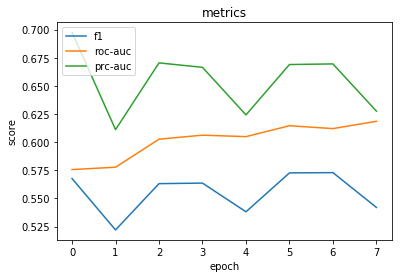

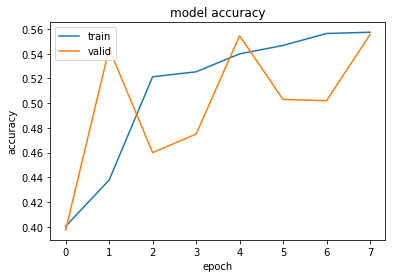

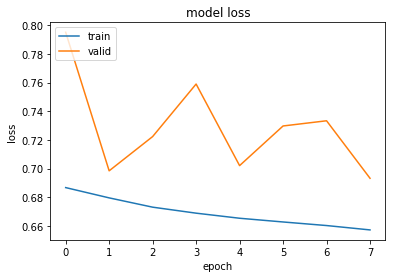

The f1_score on the test_set was 0.55
The auroc on the test_set was 0.617
The auprc on the test_set was 0.484


In [39]:
plot_metrics(metrics)
plot_history(history)
print_scores(model, test_data_word2vec, test_y.values)

# Attention

In [40]:
hidden_layer = 32
epochs = 15

inputs = keras.layers.Input(shape=(final_max, word_vec_length))
sequences = keras.layers.Bidirectional(
    keras.layers.LSTM(hidden_layer, return_sequences=True))(inputs)
sequences = keras.layers.LSTM(hidden_layer, return_sequences=True)(sequences)
seq_last = keras.layers.Lambda(lambda x: x[:, -1, :])(sequences)
# Attention
drop1 = keras.layers.Dropout(0.5)(seq_last)
dense1 = keras.layers.Dense(32, activation='relu')(drop1)
attention = keras.layers.Dense(final_max, activation="softmax")(dense1)
context = keras.layers.dot([attention, sequences], axes=1)

dropout = keras.layers.Dropout(0.5)(context)
dense2 = keras.layers.Dense(32, activation='relu')(dropout)
output = keras.layers.Dense(1, activation='sigmoid')(dense2)
model = keras.models.Model(inputs=inputs, outputs=[output])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(train_data_word2vec, train_y.values, validation_data=(valid_data_word2vec, valid_y.values),
                    epochs=epochs, batch_size=batch_size, class_weight=class_weight,
                    shuffle=True, verbose=1, callbacks=[metrics])

Train on 6000 samples, validate on 2000 samples
Epoch 1/15
6000/6000 [==============================] - 11s 2ms/sample - loss: 0.6848 - binary_accuracy: 0.4048 - val_loss: 0.7063 - val_binary_accuracy: 0.4465
Epoch 2/15
6000/6000 [==============================] - 9s 2ms/sample - loss: 0.6778 - binary_accuracy: 0.4755 - val_loss: 0.6960 - val_binary_accuracy: 0.5130
Epoch 3/15
6000/6000 [==============================] - 10s 2ms/sample - loss: 0.6753 - binary_accuracy: 0.4945 - val_loss: 0.7011 - val_binary_accuracy: 0.5090
Epoch 4/15
6000/6000 [==============================] - 10s 2ms/sample - loss: 0.6699 - binary_accuracy: 0.5100 - val_loss: 0.7480 - val_binary_accuracy: 0.4690
Epoch 5/15
6000/6000 [==============================] - 10s 2ms/sample - loss: 0.6663 - binary_accuracy: 0.5333 - val_loss: 0.6918 - val_binary_accuracy: 0.5375
Epoch 6/15
6000/6000 [==============================] - 10s 2ms/sample - loss: 0.6645 - binary_accuracy: 0.5507 - val_loss: 0.7305 - val_binary_accu

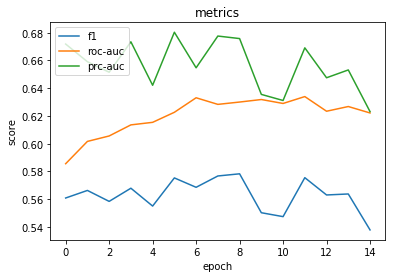

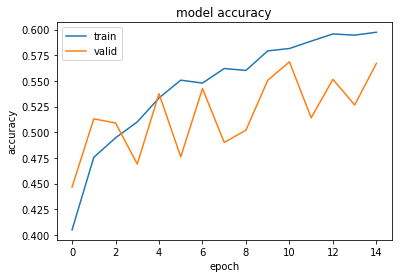

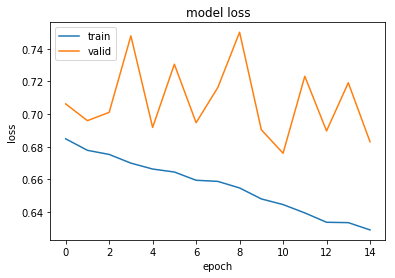

The f1_score on the test_set was 0.529
The auroc on the test_set was 0.613
The auprc on the test_set was 0.493


In [41]:
plot_metrics(metrics)
plot_history(history)
print_scores(model, test_data_word2vec, test_y.values)

## Conclusion RNNs

* We tried two RNNs, one simple LSTM-Network and one with Attention - both achieved nearly the same scores
* The scores where in line with the scores from USE - we could not improve on them
* The f1 score on the simple RNN was higher than on the attention-model
* Weighting affected the scores positively
* Longer training time could achieve higher scores ?
* Next time, we will use randomSearch to find the optimal parameters for the models